In [1]:
import shioaji as sj
from datetime import datetime, timedelta
import pandas as pd
import pytz
import json
import matplotlib.pyplot as plt
import time
%matplotlib inline

import os
parent = os.path.dirname(os.path.abspath("__file__"))

In [15]:
api = sj.Shioaji()

api.login('F128497445', '89118217k')

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


[FutureAccount(person_id='F128497445', broker_id='F002000', account_id='1473661', signed=True, username='鄭圳宏'),
 Account(account_type=<AccountType.H: 'H'>, person_id='F128497445', broker_id='9A92', account_id='0011645', username='鄭圳宏'),
 StockAccount(person_id='F128497445', broker_id='9A92', account_id='0231901', signed=True, username='鄭圳宏\u3000\u3000')]

In [2]:
def getNearbyCode(td:datetime):
    month = getNearbyMonth(td)
    return [chr(m+65-1), chr(m+65-1+12)]
    
def getNearbyMonth(td: datetime = None):
    if not td:
        td = datetime.today()
    month = td.month
    if isTimetoMaturity(td): 
        month += 1
        if month > 12:
            month = 1
    return month

def getExistsContract(date: datetime, strikes:list, symbol:str='TXF', months:int=3) -> list:
    global call_code_map, put_code_map, opt_ticker_map
    opt_ticker = opt_ticker_map[symbol]
    Conti_Ms = getExistsContractMonth(date)
    contracts = []
    y = date.year
    next_y = y + 1
    for strike in strikes:
        strike = StrikeFill(strike, symbol)
        
        for m in Conti_Ms[:months]:
            call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(y)[-1]}'
            put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(y)[-1]}'
            if 12 in Conti_Ms[1:3]:
                if m < 12:
                    call_ticker = f'{opt_ticker}{str(strike).zfill(5)}{call_code_map[m]}{str(next_y)[-1]}'
                    put_ticker = f'{opt_ticker}{str(strike).zfill(5)}{put_code_map[m]}{str(next_y)[-1]}'
            contracts.extend([call_ticker, put_ticker])
    return contracts

def getExistsContractMonth(date):
    month = getNearbyMonth(date)
    conti_Ms = [x if x <= 12 else x - 12 for x in range(month, month + 3)]
    if conti_Ms[-1] in [3, 4, 5]: # 3個連續月份的最後一個月是3或4或5，判斷連續季月月份，以下雷同
        conti_Ms.extend([6, 9, 12])
    elif conti_Ms[-1] in [6, 7, 8]:
        conti_Ms.extend([9, 12, 3])
    elif conti_Ms[-1] in [9, 10, 11]:
        conti_Ms.extend([12, 3, 6])
    elif conti_Ms[-1] in [12, 1, 2]:
        conti_Ms.extend([3, 6, 9])
    return conti_Ms

def isTimetoMaturity(td):
    thirdWendesday = getThirdWendesday(td)
    if td.strftime('%Y%m%d') >= thirdWendesday.strftime('%Y%m%d'): 
        return True
    return False

def getThirdWendesday(td):
    week = 2
    first_wendesday = getFirstWendesday(td)
    return first_wendesday + timedelta(week * 7)

def getFirstWendesday(td):
    first_day = datetime(td.year, td.month, 2)
    if first_day.weekday() <= 2:
        adj_days = 2 - first_day.weekday()
    else:
        adj_days = 9 - first_day.weekday()
    return first_day + timedelta(adj_days)

def getContiCode(td:datetime):
    m = getNearbyMonth(td)
    next_m = (m + 1) % 12
    if not next_m:
        next_m = 12
    if m+1 > 12: 
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year + 1)[-1]]
    else:
        return [chr(m+65-1)+str(td.year)[-1], chr(next_m+65-1)+str(td.year)[-1]]
    

In [13]:
def ReadData(date):
    data_path = os.path.join(parent, "HistoricData", "MXF")
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
#     for k, v in dfs.items():
    tdStr = date.strftime("%Y-%m-%d")
    try:
        with open(os.path.join(data_path, f"MXF_{tdStr}.json"), 'r') as f:
            data = json.load(f)
            df = pd.DataFrame(data)
            df.datetime = pd.to_datetime(df.datetime)
        return df.set_index('datetime')
    except:
        return pd.DataFrame()

def GetPairData(api, date:datetime=datetime(2021,11,5)):
    df = ReadData(date)
    if not df.empty:
        return df
    dateStr = date.strftime("%Y-%m-%d")
    last_code = getContiCode(date)
    today_last_code = getContiCode(datetime.today())
    
    contract_nearby = api.Contracts.Futures["MXF"+today_last_code[0]]
    contract_nearby.code = "MXF"+last_code[0]
    data_nearby = api.ticks(contract_nearby, dateStr, 
                            query_type=sj.constant.TicksQueryType.RangeTime, 
                            time_start='08:45:00',#datetime(2021,11,5,8,45,0).time(),
                           time_end='13:45:00')#datetime(2021,11,5,13,45,0).time())

    df_nearby = pd.DataFrame(data_nearby.dict())
    df_nearby['datetime'] = df_nearby.ts.apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).astimezone(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d %H:%M:%S.")+str(x)[10:16])
    df_nearby['datetime'] = pd.to_datetime(df_nearby['datetime'])

    df_nearby = df_nearby.set_index('datetime')
    return df_nearby

In [61]:
def Backtest(df, takeprofit = 20, stoploss = 40, gap_threshold = 0.1, inverse_threshold=80, pre_day_close = None):

    setup_param = False
    entry = sig = pos = 0
    interval_h = 0 # 區間高點
    interval_l = 99999 # 區間低點
    gap = 0
    
    result = []
    pre_close = None
    total_pnl = 0
    total_win = 0
    total_loss = 0
    win_trade = 0
    loss_trade = 0
    record = {}
    end_Trade = False
    tmp_min_pnl = tmp_max_pnl = min_pnl = max_pnl = 0
    tmp_sl = 10 # stoploss
    loss_num = 0
    max_unreal = 0
    max_price = 0
    min_price = 99999
    entry = 0
    zero_trade = 0
    sig_inverse = 1
    critical_h = critical_l = None
    prefer_short = prefer_long = False
    check_dir = False
    if pre_day_close:
        critical_h = pre_day_close * 1.007
        critical_l = pre_day_close * 0.993
        print(critical_h, critical_l)
    for row in df.itertuples():
        if not np.isnan(row.close) and not setup_param:
            interval_h = max(interval_h, row.close)
            interval_l = min(interval_l, row.close)
            pre_close = row.close
        
        if not check_dir:
            print("Open Price = " + str(row.close))
            if row.close <= critical_l:
                prefer_short = True
                print("跳空開低")
            elif row.close >= critical_h:
                prefer_long = True
                print("跳空開高")
            else:
                stoploss *= .5
                print("無跳空")
            check_dir = True
        if (prefer_short or prefer_long):
            if row.Index <= row.Index.replace(hour=8, minute=50, second=0, microsecond=0):
                continue
        else:
            if row.Index <= row.Index.replace(hour=9, minute=5, second=0, microsecond=0):
                continue
        if not setup_param:
            gap = (interval_h - interval_l) * gap_threshold
            if not gap:
                break
            setup_param = True
            if (interval_h - interval_l) > inverse_threshold:
                sig_inverse = -1
            mid = (interval_h + interval_l) / 2
            print(interval_h, interval_l, mid, round(gap, 2))
#         if row.Index <= row.Index.replace(hour=9, minute=25, second=0, microsecond=0):
#             pre_close = row.close
#             continue
        if row.Index <= row.Index.replace(hour=13, minute=0, second=0, microsecond=0) and not end_Trade:
            if sig == 0 and pos == 0 and not end_Trade:
#                 if row.close > interval_h + gap:
                num_trade = win_trade + loss_trade + zero_trade
                if row.close > interval_h + gap:# and pre_close <= interval_h + gap:# and prefer_long:
                    sig = 1 * sig_inverse #(-1 if (row.close - interval_h) > (interval_h - interval_l) else 1)
#                 elif row.close > mid + gap and pre_close <= mid + gap and num_trade:
# #                 if row.close >= interval_h + gap and pre_close < interval_h + gap:
#                     sig = 1 * sig_inverse #* (-1 if (row.close - interval_h) > (interval_h - interval_l) else 1)
#                 elif row.close < interval_l - gap:
                elif row.close < interval_l - gap:# and pre_close >= interval_l - gap:# and prefer_short:
                    sig = -1 * sig_inverse # (-1 if (row.close - interval_l) < -(interval_h - interval_l) else 1)
#                 elif row.close < mid - gap and pre_close >= mid - gap and num_trade:
# #                 elif row.close <= interval_l - gap and pre_close > interval_l - gap:
#                     sig = -1 * sig_inverse #* (-1 if (row.close - interval_l) < -(interval_h - interval_l) else 1)
                if sig != 0:# and pos == 0:
                    print(f"{row.Index}, PreClose : {pre_close}, Close : {row.close}, Ask : {row.ask_price}, Bid : {row.bid_price}")
                    if sig > 0:
#                         if row.ask_price >= row.close:
                        entry  = row.ask_price
                    elif sig < 0:
#                         if row.bid_price <= row.close:
                        entry  = row.bid_price
                    if entry:
                        pos = sig
                        print(f'Entry : {entry}, pos : {pos} at ts : {row.Index}, Close = {row.close}')
                    sig = 0
            if sig == 0 and pos != 0:
                if pos < 0:
                    exit = min(row.ask_price, row.close)
                    min_price = min(min_price, row.close)
                elif pos > 0:
                    exit = max(row.bid_price, row.close)
                    max_price = max(max_price, row.close)
                
                tmp_pnl = (exit - entry) * pos
                
                tmp_min_pnl = min(tmp_pnl, tmp_min_pnl)
                tmp_max_pnl = max(tmp_pnl, tmp_max_pnl)
                tmp_sl = 10 + tmp_max_pnl
#                 print(tmp_pnl,)
#                 print(entry,row.close,max_price,min_price,tmp_pnl,tmp_max_pnl,tmp_min_pnl, (tmp_pnl <= tmp_max_pnl / 2 and tmp_max_pnl >= stoploss / 2))
                if pos > 0:
#                     if (row.close <= mid and sig_inverse == 1) or row.close <= max_price - stoploss:# or (tmp_pnl <= tmp_max_pnl / 2 and tmp_max_pnl >= stoploss / 3):# and (total_pnl < 0 and not win_trade)):
                    if row.close <= max_price - stoploss or tmp_pnl >= takeprofit:# or (tmp_pnl <= tmp_max_pnl / 2 and tmp_max_pnl >= stoploss / 3):# and (total_pnl < 0 and not win_trade)):
                        print(f"Max Price : {max_price}")
                        sig = -pos
                elif pos < 0:
#                     if (row.close >= mid and sig_inverse == 1) or row.close >= min_price + stoploss:# or (tmp_pnl <= tmp_max_pnl / 2 and tmp_max_pnl >= stoploss / 3):# and (not total_pnl < 0 and not win_trade)):
                    if row.close >= min_price + stoploss or tmp_pnl >= takeprofit:# or (tmp_pnl <= tmp_max_pnl / 2 and tmp_max_pnl >= stoploss / 3):# and (not total_pnl < 0 and not win_trade)):
                        print(f"Min Price : {min_price}")
                        sig = -pos

                if sig != 0:
                    print(f"Max Pnl : {tmp_max_pnl}, Min Pnl : {tmp_min_pnl}")
                    tmp_min_pnl = tmp_max_pnl = 0
                    print(f"PreClose : {pre_close}, Close : {row.close}, Ask : {row.ask_price}, Bid : {row.bid_price}")
                    pnl = (exit - entry) * pos - 2
                    total_pnl += pnl #- 2
                    if pnl > 0:
                        win_trade += 1
                        total_win += pnl
                    elif pnl < 0:
                        loss_trade += 1
                        total_loss += pnl
                    else:
                        zero_trade += 1
                    print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.Index}, Close = {row.close}\n')
                    max_unreal = entry = exit = pos = sig = 0
                    max_pnl = max(total_pnl, max_pnl)
                    min_pnl = min(total_pnl, min_pnl)
                    max_price = 0
                    min_price = 99999
                    tmp_max_pnl = tmp_min_pnl = 0
#                     if win_trade > 0 and loss_trade > 0:
#                     if (total_pnl > 0 or loss_trade >= 3 or total_pnl < -stoploss) or (total_pnl < 0 and win_trade > 0):
#                     if loss_trade >= 3:# or win_trade >= 1:
#                     if total_pnl > 0 or total_pnl <= -stoploss * 1.5:
#                         end_Trade = True
#                     if total_pnl < 0 and not win_trade and loss_trade > 1:
#                         takeprofit = int(stoploss / 2) # stoploss #
#                         stoploss *=2
#                         gap *= 2
        else:
            if not pos:continue
            if pos < 0:
                exit = row.ask_price
            elif pos > 0:
                exit = row.bid_price
            sig = -pos

            if sig != 0:
                pnl = (exit - entry) * pos - 2
                total_pnl += pnl
                if pnl > 0:
                    win_trade += 1
                    total_win += pnl
                elif pnl < 0:
                    loss_trade += 1
                    total_loss += pnl
                else:
                    zero_trade += 1
                print(f'Exit : {exit}, pnl : {pnl}, total_pnl : {total_pnl} at ts : {row.Index}, Close = {row.close}\n')
                max_unreal = entry = exit = pos = sig = 0
                max_pnl = max(total_pnl, max_pnl)
                min_pnl = min(total_pnl, min_pnl)
                max_price = 0
                min_price = 99999
                end_Trade = True
#         print(pre_close, row.close)
        pre_close = row.close
#         print(pre_close, row.close, "\n")

    avg_win = total_win / win_trade if win_trade else 0
    avg_loss = total_loss / loss_trade if loss_trade else 0
    Q = avg_win / abs(avg_loss) if avg_loss else 0
    total_trade = win_trade + loss_trade + zero_trade
    Pw = win_trade / total_trade if total_trade else 0
    Ev = Q * Pw - (1 - Pw)
    Avg_PnL = total_pnl / total_trade if total_trade else 0
    print(f"------------Strategy Result at {row.Index.strftime('%Y-%m-%d')}------------")
    print(f'Total PnL : {total_pnl}')
    print(f'Avg Win : {avg_win}')
    print(f'Num Win : {win_trade}')
    print(f'Avg Loss : {avg_loss}')
    print(f'Num Loss : {loss_trade}')
    print(f'Avg PnL : {Avg_PnL}')
    print(f'G/L : {Q}, Pw : {Pw}, Expected Value : {Ev}')
    print(f'Max Pnl : {max_pnl}, Min Pnl : {min_pnl}\n')
    print("===================End BackTest===================\n")
    return (total_pnl, avg_win, win_trade, avg_loss, loss_trade, Avg_PnL, Q, Pw, Ev)

In [56]:
df = GetPairData(api, date=datetime(2021,2,17))

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='datetime'>

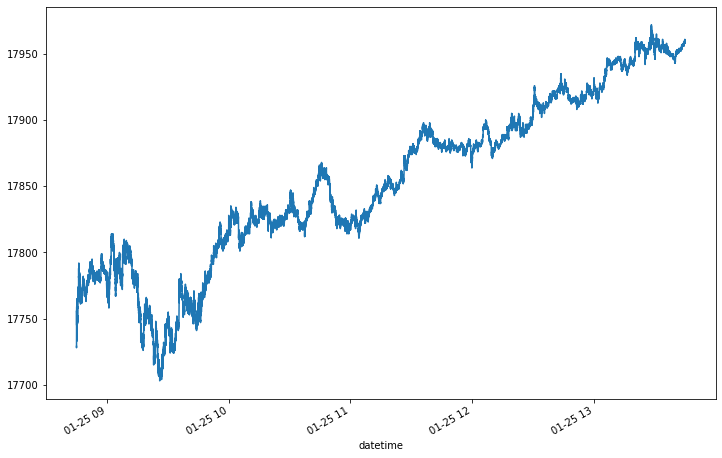

In [50]:
df.close.plot(figsize=(12,8))

In [62]:
date = datetime(2022,1,24)
# dfs[date] = GetPairData(api, date=date)
# dfs[date].close.plot(figsize=(12,8))
# df = GetPairData(api, date)
result = Backtest(df, takeprofit = 20, stoploss = 60, gap_threshold=0.3, inverse_threshold=80, pre_day_close = 17896)

18021.271999999997 17770.728
Open Price = 17729.0
跳空開低
17792.0 17728.0 17760.0 19.2
2022-01-24 09:02:11.160000, PreClose : 17810.0, Close : 17812.0, Ask : 17811.0, Bid : 17810.0
Entry : 17811.0, pos : 1 at ts : 2022-01-24 09:02:11.160000, Close = 17812.0
Max Price : 17814.0
Max Pnl : 3.0, Min Pnl : -56.0
PreClose : 17755.0, Close : 17754.0, Ask : 17756.0, Bid : 17755.0
Exit : 17755.0, pnl : -58.0, total_pnl : -58.0 at ts : 2022-01-24 09:15:36.367000, Close = 17754.0

2022-01-24 09:25:24.682000, PreClose : 17709.0, Close : 17708.0, Ask : 17711.0, Bid : 17710.0
Entry : 17710.0, pos : -1 at ts : 2022-01-24 09:25:24.682000, Close = 17708.0
Min Price : 17703.0
Max Pnl : 7.0, Min Pnl : -52.0
PreClose : 17762.0, Close : 17763.0, Ask : 17762.0, Bid : 17761.0
Exit : 17762.0, pnl : -54.0, total_pnl : -112.0 at ts : 2022-01-24 09:35:33.714000, Close = 17763.0

2022-01-24 09:55:16.225000, PreClose : 17811.0, Close : 17812.0, Ask : 17812.0, Bid : 17811.0
Entry : 17812.0, pos : 1 at ts : 2022-01-24 

In [43]:
17896*1.007, 17896*0.993

(18021.271999999997, 17770.728)

In [380]:
# results = {}
# dfs = {}
for date in pd.date_range(datetime(2021,1,4), datetime(2022,1,21)):
    try:
        if date not in dfs.keys():
            dfs[date] = GetPairData(api, date=date)
        if dfs[date] is None or dfs[date].empty:
            print(f'===============No Data on {date.strftime("%Y-%m-%d")}===============')
            continue
        print(f'===============Backtest {date.strftime("%Y-%m-%d")}===============')
        results[date] = Backtest(dfs[date], takeprofit = 8, stoploss = 30, gap_threshold=0.2)
        time.sleep(0.5)
    except KeyboardInterrupt:
        break
    except:
        pass

===============Backtest 2021-01-04===============
14674.0 14636.0 14655.0 7.6
------------Strategy Result at 2021-01-04------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-01-05===============
14890.0 14855.0 14872.5 7.0
2021-01-05 09:25:04.971000, PreClose : 14897.0, Close : 14898.0, Ask : 14898.0, Bid : 14896.0
Entry : 14896.0, pos : -1 at ts : 2021-01-05 09:25:04.971000, Close = 14898.0
Min Price : 14836.0
Max Pnl : 60.0, Min Pnl : -5.0
PreClose : 14865.0, Close : 14866.0, Ask : 14865.0, Bid : 14864.0
Exit : 14865.0, pnl : 29.0, total_pnl : 29.0 at ts : 2021-01-05 09:39:49.044000, Close = 14866.0

------------Strategy Result at 2021-01-05------------
Total PnL : 29.0
Avg Win : 29.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 29.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 29.0, Min Pnl : 0

====

===============Backtest 2021-01-14===============
15705.0 15652.0 15678.5 10.6
2021-01-14 09:31:39.010000, PreClose : 15688.0, Close : 15863.0, Ask : 15689.0, Bid : 15688.0
Entry : 15688.0, pos : -1 at ts : 2021-01-14 09:31:39.010000, Close = 15863.0
Min Price : 15632.0
Max Pnl : 56.0, Min Pnl : -3.0
PreClose : 15661.0, Close : 15662.0, Ask : 15661.0, Bid : 15660.0
Exit : 15661.0, pnl : 25.0, total_pnl : 25.0 at ts : 2021-01-14 09:42:14.361000, Close = 15662.0

------------Strategy Result at 2021-01-14------------
Total PnL : 25.0
Avg Win : 25.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 25.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 25.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-01-15===============
16002.0 15904.0 15953.0 19.6
2021-01-15 09:27:58.884000, PreClose : 15885.0, Close : 15883.0, Ask : 15884.0, Bid : 15882.0
Entry : 15884.0, pos : 1 at ts : 2021-01-15 09:27:58.884000, Close = 15883.0
Max Price : 15899.0
Max 

===============No Data on 2021-01-23===============
===============No Data on 2021-01-24===============
===============Backtest 2021-01-25===============
16004.0 15880.0 15942.0 24.8
2021-01-25 09:36:51.506000, PreClose : 15856.0, Close : 15855.0, Ask : 15859.0, Bid : 15858.0
Entry : 15859.0, pos : 1 at ts : 2021-01-25 09:36:51.506000, Close = 15855.0
Max Price : 15857.0
Max Pnl : 0, Min Pnl : -29.0
PreClose : 15828.0, Close : 15827.0, Ask : 15831.0, Bid : 15830.0
Exit : 15830.0, pnl : -31.0, total_pnl : -31.0 at ts : 2021-01-25 09:38:28.522000, Close = 15827.0

2021-01-25 10:20:38.664000, PreClose : 15856.0, Close : 15855.0, Ask : 15856.0, Bid : 15854.0
Entry : 15856.0, pos : 1 at ts : 2021-01-25 10:20:38.664000, Close = 15855.0
Max Price : 15888.0
Max Pnl : 32.0, Min Pnl : -2.0
PreClose : 15859.0, Close : 15858.0, Ask : 15860.0, Bid : 15859.0
Exit : 15859.0, pnl : 1.0, total_pnl : -30.0 at ts : 2021-01-25 10:26:14.789000, Close = 15858.0

2021-01-25 10:26:16.193000, PreClose : 15856.

2021-02-01 09:47:10.047000, PreClose : 15239.0, Close : 15240.0, Ask : 15236.0, Bid : 15234.0
Entry : 15234.0, pos : -1 at ts : 2021-02-01 09:47:10.047000, Close = 15240.0
Min Price : 15204.0
Max Pnl : 30.0, Min Pnl : -12.0
PreClose : 15233.0, Close : 15234.0, Ask : 15233.0, Bid : 15232.0
Exit : 15233.0, pnl : -1.0, total_pnl : -1.0 at ts : 2021-02-01 09:51:52.285000, Close = 15234.0

2021-02-01 09:53:02.574000, PreClose : 15239.0, Close : 15240.0, Ask : 15238.0, Bid : 15236.0
Entry : 15236.0, pos : -1 at ts : 2021-02-01 09:53:02.574000, Close = 15240.0
Min Price : 15173.0
Max Pnl : 63.0, Min Pnl : -8.0
PreClose : 15202.0, Close : 15203.0, Ask : 15198.0, Bid : 15196.0
Exit : 15198.0, pnl : 36.0, total_pnl : 35.0 at ts : 2021-02-01 10:00:25.009000, Close = 15203.0

------------Strategy Result at 2021-02-01------------
Total PnL : 35.0
Avg Win : 36.0
Num Win : 1
Avg Loss : -1.0
Num Loss : 1
Avg PnL : 17.5
G/L : 36.0, Pw : 0.5, Expected Value : 17.5
Max Pnl : 35.0, Min Pnl : -1.0

=======

------------Strategy Result at 2021-02-19------------
Total PnL : -46.0
Avg Win : 0
Num Win : 0
Avg Loss : -23.0
Num Loss : 2
Avg PnL : -23.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -46.0

===================End BackTest===================

===============No Data on 2021-02-20===============
===============No Data on 2021-02-21===============
===============Backtest 2021-02-22===============
16508.0 16416.0 16462.0 18.4
2021-02-22 09:25:30.086000, PreClose : 16526.0, Close : 16527.0, Ask : 16527.0, Bid : 16526.0
Entry : 16526.0, pos : -1 at ts : 2021-02-22 09:25:30.086000, Close = 16527.0
Min Price : 16470.0
Max Pnl : 56.0, Min Pnl : -4.0
PreClose : 16499.0, Close : 16500.0, Ask : 16498.0, Bid : 16497.0
Exit : 16498.0, pnl : 26.0, total_pnl : 26.0 at ts : 2021-02-22 09:28:40.973000, Close = 16500.0

------------Strategy Result at 2021-02-22------------
Total PnL : 26.0
Avg Win : 26.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 26.0
G/L : 0, Pw : 1.0, Expec

2021-03-03 09:41:19.306000, PreClose : 15970.0, Close : 15969.0, Ask : 15969.0, Bid : 15968.0
Entry : 15969.0, pos : 1 at ts : 2021-03-03 09:41:19.306000, Close = 15969.0
Max Price : 16015.0
Max Pnl : 46.0, Min Pnl : -12.0
PreClose : 15986.0, Close : 15985.0, Ask : 15987.0, Bid : 15986.0
Exit : 15986.0, pnl : 15.0, total_pnl : 15.0 at ts : 2021-03-03 09:57:37.248000, Close = 15985.0

------------Strategy Result at 2021-03-03------------
Total PnL : 15.0
Avg Win : 15.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 15.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 15.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-03-04===============
16063.0 15981.0 16022.0 16.4
2021-03-04 09:39:00.527000, PreClose : 15965.0, Close : 15964.0, Ask : 15966.0, Bid : 15965.0
Entry : 15966.0, pos : 1 at ts : 2021-03-04 09:39:00.527000, Close = 15964.0
Max Price : 15970.0
Max Pnl : 4.0, Min Pnl : -25.0
PreClose : 15941.0, Close : 15940.0, Ask : 15942.0, 

===============Backtest 2021-03-12===============
16285.0 16224.0 16254.5 12.2
2021-03-12 09:25:06.313000, PreClose : 16212.0, Close : 16211.0, Ask : 16212.0, Bid : 16211.0
Entry : 16212.0, pos : 1 at ts : 2021-03-12 09:25:06.313000, Close = 16211.0
Max Price : 16260.0
Max Pnl : 48.0, Min Pnl : -2.0
PreClose : 16231.0, Close : 16230.0, Ask : 16232.0, Bid : 16230.0
Exit : 16230.0, pnl : 16.0, total_pnl : 16.0 at ts : 2021-03-12 09:37:30.813000, Close = 16230.0

------------Strategy Result at 2021-03-12------------
Total PnL : 16.0
Avg Win : 16.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 16.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 16.0, Min Pnl : 0

===================End BackTest===================

===============No Data on 2021-03-13===============
===============No Data on 2021-03-14===============
===============Backtest 2021-03-15===============
16217.0 16166.0 16191.5 10.2
2021-03-15 09:41:03.725000, PreClose : 16156.0, Close : 16155.0, Ask : 16160.0, Bid : 16159.

------------Strategy Result at 2021-03-25------------
Total PnL : -31.0
Avg Win : 0
Num Win : 0
Avg Loss : -31.0
Num Loss : 1
Avg PnL : -31.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -31.0

===================End BackTest===================

===============Backtest 2021-03-26===============
16123.0 16088.0 16105.5 7.0
2021-03-26 09:30:14.040000, PreClose : 16130.0, Close : 16131.0, Ask : 16130.0, Bid : 16129.0
Entry : 16129.0, pos : -1 at ts : 2021-03-26 09:30:14.040000, Close = 16131.0
Min Price : 16130.0
Max Pnl : 0, Min Pnl : -28.0
PreClose : 16159.0, Close : 16160.0, Ask : 16157.0, Bid : 16156.0
Exit : 16157.0, pnl : -30.0, total_pnl : -30.0 at ts : 2021-03-26 09:35:01.727000, Close = 16160.0

------------Strategy Result at 2021-03-26------------
Total PnL : -30.0
Avg Win : 0
Num Win : 0
Avg Loss : -30.0
Num Loss : 1
Avg PnL : -30.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -30.0

===================End BackTest===================

=

------------Strategy Result at 2021-04-12------------
Total PnL : 21.0
Avg Win : 21.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 21.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 21.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-04-13===============
16930.0 16890.0 16910.0 8.0
2021-04-13 09:27:40.018000, PreClose : 16938.0, Close : 16939.0, Ask : 16938.0, Bid : 16937.0
Entry : 16937.0, pos : -1 at ts : 2021-04-13 09:27:40.018000, Close = 16939.0
Min Price : 16926.0
Max Pnl : 11.0, Min Pnl : -16.0
PreClose : 16955.0, Close : 16956.0, Ask : 16953.0, Bid : 16952.0
Exit : 16953.0, pnl : -18.0, total_pnl : -18.0 at ts : 2021-04-13 09:40:09.755000, Close = 16956.0

------------Strategy Result at 2021-04-13------------
Total PnL : -18.0
Avg Win : 0
Num Win : 0
Avg Loss : -18.0
Num Loss : 1
Avg PnL : -18.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -18.0

===================End BackTest===================

=====

===============Backtest 2021-04-22===============
17325.0 17256.0 17290.5 13.8
2021-04-22 09:57:37.528000, PreClose : 17243.0, Close : 17242.0, Ask : 17245.0, Bid : 17243.0
Entry : 17245.0, pos : 1 at ts : 2021-04-22 09:57:37.528000, Close = 17242.0
Max Price : 17262.0
Max Pnl : 17.0, Min Pnl : -22.0
PreClose : 17233.0, Close : 17232.0, Ask : 17235.0, Bid : 17234.0
Exit : 17234.0, pnl : -13.0, total_pnl : -13.0 at ts : 2021-04-22 10:10:44.397000, Close = 17232.0

2021-04-22 10:11:47.707000, PreClose : 17243.0, Close : 17242.0, Ask : 17243.0, Bid : 17242.0
Entry : 17243.0, pos : 1 at ts : 2021-04-22 10:11:47.707000, Close = 17242.0
Max Price : 17293.0
Max Pnl : 50.0, Min Pnl : -6.0
PreClose : 17264.0, Close : 17263.0, Ask : 17266.0, Bid : 17265.0
Exit : 17265.0, pnl : 20.0, total_pnl : 7.0 at ts : 2021-04-22 10:37:50.591000, Close = 17263.0

------------Strategy Result at 2021-04-22------------
Total PnL : 7.0
Avg Win : 20.0
Num Win : 1
Avg Loss : -13.0
Num Loss : 1
Avg PnL : 3.5
G/L : 

Min Price : 16914.0
Max Pnl : 51.0, Min Pnl : -1.0
PreClose : 16943.0, Close : 16944.0, Ask : 16943.0, Bid : 16942.0
Exit : 16943.0, pnl : 20.0, total_pnl : 9.0 at ts : 2021-05-06 11:11:35.351000, Close = 16944.0

------------Strategy Result at 2021-05-06------------
Total PnL : 9.0
Avg Win : 20.0
Num Win : 1
Avg Loss : -11.0
Num Loss : 1
Avg PnL : 4.5
G/L : 1.8181818181818181, Pw : 0.5, Expected Value : 0.40909090909090906
Max Pnl : 9.0, Min Pnl : -11.0

===================End BackTest===================

===============Backtest 2021-05-07===============
17156.0 17106.0 17131.0 10.0
2021-05-07 09:27:29.357000, PreClose : 17096.0, Close : 17095.0, Ask : 17100.0, Bid : 17098.0
Entry : 17100.0, pos : 1 at ts : 2021-05-07 09:27:29.357000, Close = 17095.0
Max Price : 17116.0
Max Pnl : 16.0, Min Pnl : -14.0
PreClose : 17087.0, Close : 17086.0, Ask : 17089.0, Bid : 17088.0
Exit : 17088.0, pnl : -14.0, total_pnl : -14.0 at ts : 2021-05-07 09:32:20.369000, Close = 17086.0

2021-05-07 09:33:24.

===============Backtest 2021-05-18===============
15643.0 15500.0 15571.5 28.6
------------Strategy Result at 2021-05-18------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-05-19===============
16086.0 15987.0 16036.5 19.8
2021-05-19 09:35:51.778000, PreClose : 15968.0, Close : 15967.0, Ask : 15969.0, Bid : 15967.0
Entry : 15969.0, pos : 1 at ts : 2021-05-19 09:35:51.778000, Close = 15967.0
Max Price : 16030.0
Max Pnl : 61.0, Min Pnl : -21.0
PreClose : 16001.0, Close : 16000.0, Ask : 16004.0, Bid : 16001.0
Exit : 16001.0, pnl : 30.0, total_pnl : 30.0 at ts : 2021-05-19 09:39:13.021000, Close = 16000.0

------------Strategy Result at 2021-05-19------------
Total PnL : 30.0
Avg Win : 30.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 30.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 30.0, Min Pnl : 0

==

Max Price : 16614.0
Max Pnl : 21.0, Min Pnl : -21.0
PreClose : 16585.0, Close : 16584.0, Ask : 16589.0, Bid : 16588.0
Exit : 16588.0, pnl : -7.0, total_pnl : -46.0 at ts : 2021-05-26 09:46:45.456000, Close = 16584.0

------------Strategy Result at 2021-05-26------------
Total PnL : -46.0
Avg Win : 0
Num Win : 0
Avg Loss : -15.333333333333334
Num Loss : 3
Avg PnL : -15.333333333333334
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -46.0

===================End BackTest===================

===============Backtest 2021-05-27===============
16599.0 16201.0 16400.0 79.6
------------Strategy Result at 2021-05-27------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-05-28===============
16776.0 16692.0 16734.0 16.8
2021-05-28 09:37:32.945000, PreClose : 16676.0, Close : 16675.0, Ask : 16681.0, Bid :

2021-06-07 09:27:08.146000, PreClose : 17115.0, Close : 17113.0, Ask : 17116.0, Bid : 17114.0
Entry : 17116.0, pos : 1 at ts : 2021-06-07 09:27:08.146000, Close = 17113.0
Max Price : 17124.0
Max Pnl : 8.0, Min Pnl : -21.0
PreClose : 17095.0, Close : 17094.0, Ask : 17097.0, Bid : 17095.0
Exit : 17095.0, pnl : -23.0, total_pnl : -23.0 at ts : 2021-06-07 09:31:11.518000, Close = 17094.0

2021-06-07 11:50:19.661000, PreClose : 17114.0, Close : 17113.0, Ask : 17111.0, Bid : 17109.0
Entry : 17111.0, pos : 1 at ts : 2021-06-07 11:50:19.661000, Close = 17113.0
Max Price : 17116.0
Max Pnl : 5.0, Min Pnl : -24.0
PreClose : 17087.0, Close : 17086.0, Ask : 17089.0, Bid : 17087.0
Exit : 17087.0, pnl : -26.0, total_pnl : -49.0 at ts : 2021-06-07 11:51:12.269000, Close = 17086.0

------------Strategy Result at 2021-06-07------------
Total PnL : -49.0
Avg Win : 0
Num Win : 0
Avg Loss : -24.5
Num Loss : 2
Avg PnL : -24.5
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -49.0

=========

------------Strategy Result at 2021-06-16------------
Total PnL : -32.0
Avg Win : 0
Num Win : 0
Avg Loss : -32.0
Num Loss : 1
Avg PnL : -32.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -32.0

===================End BackTest===================

===============Backtest 2021-06-17===============
17111.0 17045.0 17078.0 13.2
2021-06-17 09:53:00.912000, PreClose : 17124.0, Close : 17125.0, Ask : 17123.0, Bid : 17122.0
Entry : 17122.0, pos : -1 at ts : 2021-06-17 09:53:00.912000, Close = 17125.0
Min Price : 17121.0
Max Pnl : 1.0, Min Pnl : -27.0
PreClose : 17150.0, Close : 17151.0, Ask : 17148.0, Bid : 17147.0
Exit : 17148.0, pnl : -28.0, total_pnl : -28.0 at ts : 2021-06-17 10:09:31.847000, Close = 17151.0

------------Strategy Result at 2021-06-17------------
Total PnL : -28.0
Avg Win : 0
Num Win : 0
Avg Loss : -28.0
Num Loss : 1
Avg PnL : -28.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -28.0

===================End BackTest===================

2021-06-29 09:34:20.360000, PreClose : 17542.0, Close : 17541.0, Ask : 17544.0, Bid : 17543.0
Entry : 17544.0, pos : 1 at ts : 2021-06-29 09:34:20.360000, Close = 17541.0
Max Price : 17541.0
Max Pnl : 0, Min Pnl : -32.0
PreClose : 17512.0, Close : 17511.0, Ask : 17514.0, Bid : 17512.0
Exit : 17512.0, pnl : -34.0, total_pnl : -34.0 at ts : 2021-06-29 09:35:49.760000, Close = 17511.0

2021-06-29 09:38:59.309000, PreClose : 17542.0, Close : 17540.0, Ask : 17541.0, Bid : 17539.0
Entry : 17541.0, pos : 1 at ts : 2021-06-29 09:38:59.309000, Close = 17540.0
Max Price : 17548.0
Max Pnl : 7.0, Min Pnl : -23.0
PreClose : 17519.0, Close : 17518.0, Ask : 17520.0, Bid : 17518.0
Exit : 17518.0, pnl : -25.0, total_pnl : -59.0 at ts : 2021-06-29 09:48:09.720000, Close = 17518.0

------------Strategy Result at 2021-06-29------------
Total PnL : -59.0
Avg Win : 0
Num Win : 0
Avg Loss : -29.5
Num Loss : 2
Avg PnL : -29.5
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -59.0

===========

------------Strategy Result at 2021-07-09------------
Total PnL : -49.0
Avg Win : 0
Num Win : 0
Avg Loss : -16.333333333333332
Num Loss : 3
Avg PnL : -16.333333333333332
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -49.0

===================End BackTest===================

===============No Data on 2021-07-10===============
===============No Data on 2021-07-11===============
===============Backtest 2021-07-12===============
17916.0 17836.0 17876.0 16.0
2021-07-12 09:29:02.393000, PreClose : 17932.0, Close : 17933.0, Ask : 17930.0, Bid : 17929.0
Entry : 17929.0, pos : -1 at ts : 2021-07-12 09:29:02.393000, Close = 17933.0
Min Price : 17931.0
Max Pnl : 0, Min Pnl : -29.0
PreClose : 17960.0, Close : 17961.0, Ask : 17958.0, Bid : 17956.0
Exit : 17958.0, pnl : -31.0, total_pnl : -31.0 at ts : 2021-07-12 09:34:01.182000, Close = 17961.0

2021-07-12 09:38:32.832000, PreClose : 17932.0, Close : 17933.0, Ask : 17935.0, Bid : 17934.0
Entry : 17934.0, pos : -1 at ts : 2021-07

------------Strategy Result at 2021-07-21------------
Total PnL : -48.0
Avg Win : 0
Num Win : 0
Avg Loss : -24.0
Num Loss : 2
Avg PnL : -24.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -48.0

===================End BackTest===================

===============Backtest 2021-07-22===============
17442.0 17408.0 17425.0 6.8
2021-07-22 10:37:14.075000, PreClose : 17447.0, Close : 17449.0, Ask : 17451.0, Bid : 17450.0
Entry : 17450.0, pos : -1 at ts : 2021-07-22 10:37:14.075000, Close = 17449.0
Min Price : 17403.0
Max Pnl : 47.0, Min Pnl : -23.0
PreClose : 17432.0, Close : 17433.0, Ask : 17433.0, Bid : 17431.0
Exit : 17433.0, pnl : 15.0, total_pnl : 15.0 at ts : 2021-07-22 10:50:39.930000, Close = 17433.0

------------Strategy Result at 2021-07-22------------
Total PnL : 15.0
Avg Win : 15.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 15.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 15.0, Min Pnl : 0

===================End BackTest===================

=======

===============Backtest 2021-08-02===============
------------Strategy Result at 2021-08-01------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-08-03===============
17458.0 17406.0 17432.0 10.4
2021-08-03 09:33:49.280000, PreClose : 17396.0, Close : 17395.0, Ask : 17399.0, Bid : 17398.0
Entry : 17399.0, pos : 1 at ts : 2021-08-03 09:33:49.280000, Close = 17395.0
Max Price : 17425.0
Max Pnl : 26.0, Min Pnl : -6.0
PreClose : 17396.0, Close : 17395.0, Ask : 17399.0, Bid : 17398.0
Exit : 17398.0, pnl : -3.0, total_pnl : -3.0 at ts : 2021-08-03 09:49:35.100000, Close = 17395.0

2021-08-03 09:49:35.129000, PreClose : 17396.0, Close : 17395.0, Ask : 17399.0, Bid : 17398.0
Entry : 17399.0, pos : 1 at ts : 2021-08-03 09:49:35.129000, Close = 17395.0
Max Price : 17413.0
Max Pnl : 14.0, Min Pnl : -14.0
PreClose : 17384.

------------Strategy Result at 2021-08-12------------
Total PnL : 64.0
Avg Win : 64.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 64.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 64.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-08-13===============
17193.0 17083.0 17138.0 22.0
2021-08-13 10:14:56.318000, PreClose : 17062.0, Close : 17060.0, Ask : 17060.0, Bid : 17058.0
Entry : 17060.0, pos : 1 at ts : 2021-08-13 10:14:56.318000, Close = 17060.0
Max Price : 17089.0
Max Pnl : 29.0, Min Pnl : -1.0
PreClose : 17060.0, Close : 17059.0, Ask : 17060.0, Bid : 17059.0
Exit : 17059.0, pnl : -3.0, total_pnl : -3.0 at ts : 2021-08-13 10:30:14.919000, Close = 17059.0

2021-08-13 10:31:00.839000, PreClose : 17061.0, Close : 17060.0, Ask : 17062.0, Bid : 17061.0
Entry : 17062.0, pos : 1 at ts : 2021-08-13 10:31:00.839000, Close = 17060.0
Max Price : 17070.0
Max Pnl : 8.0, Min Pnl : -21.0
PreClose : 17041.0, Close : 17040.0, Ask : 17042.0, B

------------Strategy Result at 2021-08-24------------
Total PnL : -24.0
Avg Win : 0
Num Win : 0
Avg Loss : -24.0
Num Loss : 1
Avg PnL : -24.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -24.0

===================End BackTest===================

===============Backtest 2021-08-25===============
16847.0 16785.0 16816.0 12.4
2021-08-25 09:33:40.630000, PreClose : 16859.0, Close : 16860.0, Ask : 16859.0, Bid : 16858.0
Entry : 16858.0, pos : -1 at ts : 2021-08-25 09:33:40.630000, Close = 16860.0
Min Price : 16859.0
Max Pnl : 0, Min Pnl : -29.0
PreClose : 16888.0, Close : 16889.0, Ask : 16887.0, Bid : 16886.0
Exit : 16887.0, pnl : -31.0, total_pnl : -31.0 at ts : 2021-08-25 09:34:02.023000, Close = 16889.0

2021-08-25 09:57:54.461000, PreClose : 16859.0, Close : 16860.0, Ask : 16865.0, Bid : 16864.0
Entry : 16864.0, pos : -1 at ts : 2021-08-25 09:57:54.461000, Close = 16860.0
Min Price : 16856.0
Max Pnl : 8.0, Min Pnl : -21.0
PreClose : 16885.0, Close : 16886.0, Ask : 1

2021-09-06 10:40:23.117000, PreClose : 17536.0, Close : 17537.0, Ask : 17538.0, Bid : 17537.0
Entry : 17537.0, pos : -1 at ts : 2021-09-06 10:40:23.117000, Close = 17537.0
Min Price : 17490.0
Max Pnl : 47.0, Min Pnl : -3.0
PreClose : 17519.0, Close : 17520.0, Ask : 17519.0, Bid : 17518.0
Exit : 17519.0, pnl : 16.0, total_pnl : -7.0 at ts : 2021-09-06 10:53:37.602000, Close = 17520.0

2021-09-06 11:05:08.923000, PreClose : 17536.0, Close : 17537.0, Ask : 17534.0, Bid : 17533.0
Entry : 17533.0, pos : -1 at ts : 2021-09-06 11:05:08.923000, Close = 17537.0
Min Price : 17514.0
Max Pnl : 19.0, Min Pnl : -12.0
PreClose : 17543.0, Close : 17544.0, Ask : 17543.0, Bid : 17542.0
Exit : 17543.0, pnl : -12.0, total_pnl : -19.0 at ts : 2021-09-06 11:46:10.327000, Close = 17544.0

------------Strategy Result at 2021-09-06------------
Total PnL : -19.0
Avg Win : 16.0
Num Win : 1
Avg Loss : -11.666666666666666
Num Loss : 3
Avg PnL : -4.75
G/L : 1.3714285714285714, Pw : 0.25, Expected Value : -0.4071428

------------Strategy Result at 2021-09-22------------
Total PnL : 25.0
Avg Win : 25.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 25.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 25.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-09-23===============
17069.0 17002.0 17035.5 13.4
2021-09-23 09:30:48.109000, PreClose : 17082.0, Close : 17083.0, Ask : 17081.0, Bid : 17078.0
Entry : 17078.0, pos : -1 at ts : 2021-09-23 09:30:48.109000, Close = 17083.0
Min Price : 17071.0
Max Pnl : 7.0, Min Pnl : -21.0
PreClose : 17100.0, Close : 17101.0, Ask : 17099.0, Bid : 17098.0
Exit : 17099.0, pnl : -23.0, total_pnl : -23.0 at ts : 2021-09-23 09:33:00.719000, Close = 17101.0

2021-09-23 09:52:08.493000, PreClose : 17082.0, Close : 17083.0, Ask : 17087.0, Bid : 17086.0
Entry : 17086.0, pos : -1 at ts : 2021-09-23 09:52:08.493000, Close = 17083.0
Min Price : 17054.0
Max Pnl : 32.0, Min Pnl : -21.0
PreClose : 17083.0, Close : 17084.0, Ask : 17083

Max Price : 16884.0
Max Pnl : 116.0, Min Pnl : -6.0
PreClose : 16855.0, Close : 16854.0, Ask : 16856.0, Bid : 16855.0
Exit : 16855.0, pnl : 85.0, total_pnl : 58.0 at ts : 2021-09-30 10:54:51.611000, Close = 16854.0

------------Strategy Result at 2021-09-30------------
Total PnL : 58.0
Avg Win : 85.0
Num Win : 1
Avg Loss : -27.0
Num Loss : 1
Avg PnL : 29.0
G/L : 3.1481481481481484, Pw : 0.5, Expected Value : 1.0740740740740742
Max Pnl : 58.0, Min Pnl : -27.0

===================End BackTest===================

===============Backtest 2021-10-01===============
16804.0 16722.0 16763.0 16.4
------------Strategy Result at 2021-10-01------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===================End BackTest===================

===============No Data on 2021-10-02===============
===============No Data on 2021-10-03===============
===============Backtest 2021-10-04===============
16630.

------------Strategy Result at 2021-10-14------------
Total PnL : -43.0
Avg Win : 0
Num Win : 0
Avg Loss : -14.333333333333334
Num Loss : 3
Avg PnL : -14.333333333333334
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -43.0

===================End BackTest===================

===============Backtest 2021-10-15===============
16679.0 16605.0 16642.0 14.8
2021-10-15 09:25:35.657000, PreClose : 16591.0, Close : 16590.0, Ask : 16591.0, Bid : 16590.0
Entry : 16591.0, pos : 1 at ts : 2021-10-15 09:25:35.657000, Close = 16590.0
Max Price : 16648.0
Max Pnl : 57.0, Min Pnl : -6.0
PreClose : 16619.0, Close : 16618.0, Ask : 16622.0, Bid : 16620.0
Exit : 16620.0, pnl : 27.0, total_pnl : 27.0 at ts : 2021-10-15 09:41:59.549000, Close = 16618.0

------------Strategy Result at 2021-10-15------------
Total PnL : 27.0
Avg Win : 27.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 27.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 27.0, Min Pnl : 0

===================End BackTest=

===============Backtest 2021-10-27===============
16992.0 16928.0 16960.0 12.8
2021-10-27 09:31:33.684000, PreClose : 17004.0, Close : 17005.0, Ask : 17004.0, Bid : 17003.0
Entry : 17003.0, pos : -1 at ts : 2021-10-27 09:31:33.684000, Close = 17005.0
Min Price : 16993.0
Max Pnl : 10.0, Min Pnl : -19.0
PreClose : 17022.0, Close : 17023.0, Ask : 17020.0, Bid : 17019.0
Exit : 17020.0, pnl : -19.0, total_pnl : -19.0 at ts : 2021-10-27 09:40:08.456000, Close = 17023.0

2021-10-27 09:44:33.407000, PreClose : 17004.0, Close : 17006.0, Ask : 17006.0, Bid : 17004.0
Entry : 17004.0, pos : -1 at ts : 2021-10-27 09:44:33.407000, Close = 17006.0
Min Price : 16961.0
Max Pnl : 43.0, Min Pnl : -4.0
PreClose : 16990.0, Close : 16991.0, Ask : 16990.0, Bid : 16989.0
Exit : 16990.0, pnl : 12.0, total_pnl : -7.0 at ts : 2021-10-27 10:00:47.182000, Close = 16991.0

2021-10-27 10:09:32.457000, PreClose : 16972.0, Close : 16973.0, Ask : 16973.0, Bid : 16972.0
Entry : 16972.0, pos : -1 at ts : 2021-10-27 10:09

Max Price : 17208.0
Max Pnl : 27.0, Min Pnl : -14.0
PreClose : 17179.0, Close : 17178.0, Ask : 17181.0, Bid : 17179.0
Exit : 17179.0, pnl : -4.0, total_pnl : -16.0 at ts : 2021-11-04 10:41:01.368000, Close = 17178.0

2021-11-04 10:41:04.072000, PreClose : 17182.0, Close : 17180.0, Ask : 17182.0, Bid : 17180.0
Entry : 17182.0, pos : 1 at ts : 2021-11-04 10:41:04.072000, Close = 17180.0
Max Price : 17186.0
Max Pnl : 4.0, Min Pnl : -22.0
PreClose : 17157.0, Close : 17156.0, Ask : 17161.0, Bid : 17160.0
Exit : 17160.0, pnl : -24.0, total_pnl : -40.0 at ts : 2021-11-04 10:44:49.040000, Close = 17156.0

------------Strategy Result at 2021-11-04------------
Total PnL : -40.0
Avg Win : 0
Num Win : 0
Avg Loss : -13.333333333333334
Num Loss : 3
Avg PnL : -13.333333333333334
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -40.0

===================End BackTest===================

===============Backtest 2021-11-05===============
17174.0 17120.0 17147.0 10.8
2021-11-05 09:42:45.4

Min Price : 17622.0
Max Pnl : 26.0, Min Pnl : -3.0
PreClose : 17651.0, Close : 17652.0, Ask : 17651.0, Bid : 17650.0
Exit : 17651.0, pnl : -5.0, total_pnl : -33.0 at ts : 2021-11-15 09:51:38.980000, Close = 17652.0

2021-11-15 09:52:39.307000, PreClose : 17668.0, Close : 17669.0, Ask : 17669.0, Bid : 17668.0
Entry : 17668.0, pos : -1 at ts : 2021-11-15 09:52:39.307000, Close = 17669.0
Min Price : 17638.0
Max Pnl : 30.0, Min Pnl : -16.0
PreClose : 17667.0, Close : 17668.0, Ask : 17668.0, Bid : 17667.0
Exit : 17668.0, pnl : -2.0, total_pnl : -35.0 at ts : 2021-11-15 10:43:56.001000, Close = 17668.0

2021-11-15 10:45:49.181000, PreClose : 17668.0, Close : 17669.0, Ask : 17668.0, Bid : 17667.0
Entry : 17667.0, pos : -1 at ts : 2021-11-15 10:45:49.181000, Close = 17669.0
Min Price : 17634.0
Max Pnl : 33.0, Min Pnl : -11.0
PreClose : 17663.0, Close : 17664.0, Ask : 17663.0, Bid : 17662.0
Exit : 17663.0, pnl : 2.0, total_pnl : -33.0 at ts : 2021-11-15 11:33:34.438000, Close = 17664.0

2021-11

===============Backtest 2021-11-23===============
17770.0 17697.0 17733.5 14.6
2021-11-23 09:30:17.557000, PreClose : 17683.0, Close : 17681.0, Ask : 17682.0, Bid : 17681.0
Entry : 17682.0, pos : 1 at ts : 2021-11-23 09:30:17.557000, Close = 17681.0
Max Price : 17744.0
Max Pnl : 62.0, Min Pnl : -6.0
PreClose : 17715.0, Close : 17714.0, Ask : 17716.0, Bid : 17715.0
Exit : 17715.0, pnl : 31.0, total_pnl : 31.0 at ts : 2021-11-23 09:57:29.062000, Close = 17714.0

------------Strategy Result at 2021-11-23------------
Total PnL : 31.0
Avg Win : 31.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 31.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 31.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2021-11-24===============
17685.0 17593.0 17639.0 18.4
------------Strategy Result at 2021-11-24------------
Total PnL : 0
Avg Win : 0
Num Win : 0
Avg Loss : 0
Num Loss : 0
Avg PnL : 0
G/L : 0, Pw : 0, Expected Value : -1
Max Pnl : 0, Min Pnl : 0

===

Exit : 17730.0, pnl : 40.0, total_pnl : 28.0 at ts : 2021-12-03 12:00:00.481000, Close = 17732.0

------------Strategy Result at 2021-12-03------------
Total PnL : 28.0
Avg Win : 29.5
Num Win : 2
Avg Loss : -15.5
Num Loss : 2
Avg PnL : 7.0
G/L : 1.903225806451613, Pw : 0.5, Expected Value : 0.4516129032258065
Max Pnl : 28.0, Min Pnl : -30.0

===================End BackTest===================

===============No Data on 2021-12-04===============
===============No Data on 2021-12-05===============
===============Backtest 2021-12-06===============
17624.0 17539.0 17581.5 17.0
2021-12-06 09:31:55.619000, PreClose : 17641.0, Close : 17642.0, Ask : 17641.0, Bid : 17640.0
Entry : 17640.0, pos : -1 at ts : 2021-12-06 09:31:55.619000, Close = 17642.0
Min Price : 17594.0
Max Pnl : 46.0, Min Pnl : -2.0
PreClose : 17623.0, Close : 17624.0, Ask : 17624.0, Bid : 17623.0
Exit : 17624.0, pnl : 14.0, total_pnl : 14.0 at ts : 2021-12-06 09:38:15.766000, Close = 17624.0

------------Strategy Result at 202

2022-01-03 09:34:19.735000, PreClose : 18369.0, Close : 18370.0, Ask : 18370.0, Bid : 18369.0
Entry : 18369.0, pos : -1 at ts : 2022-01-03 09:34:19.735000, Close = 18370.0
Min Price : 18253.0
Max Pnl : 116.0, Min Pnl : -4.0
PreClose : 18282.0, Close : 18283.0, Ask : 18280.0, Bid : 18279.0
Exit : 18280.0, pnl : 87.0, total_pnl : 87.0 at ts : 2022-01-03 10:35:34.585000, Close = 18283.0

------------Strategy Result at 2022-01-03------------
Total PnL : 87.0
Avg Win : 87.0
Num Win : 1
Avg Loss : 0
Num Loss : 0
Avg PnL : 87.0
G/L : 0, Pw : 1.0, Expected Value : 0.0
Max Pnl : 87.0, Min Pnl : 0

===================End BackTest===================

===============Backtest 2022-01-04===============
18419.0 18350.0 18384.5 13.8
2022-01-04 09:59:56.712000, PreClose : 18432.0, Close : 18433.0, Ask : 18436.0, Bid : 18435.0
Entry : 18435.0, pos : -1 at ts : 2022-01-04 09:59:56.712000, Close = 18433.0
Min Price : 18426.0
Max Pnl : 9.0, Min Pnl : -21.0
PreClose : 18455.0, Close : 18456.0, Ask : 18456.0

------------Strategy Result at 2022-01-14------------
Total PnL : -69.0
Avg Win : 0
Num Win : 0
Avg Loss : -23.0
Num Loss : 3
Avg PnL : -23.0
G/L : 0.0, Pw : 0.0, Expected Value : -1.0
Max Pnl : 0, Min Pnl : -69.0

===================End BackTest===================

===============No Data on 2022-01-15===============
===============No Data on 2022-01-16===============
===============Backtest 2022-01-17===============
18462.0 18388.0 18425.0 14.8
2022-01-17 09:29:26.036000, PreClose : 18476.0, Close : 18477.0, Ask : 18476.0, Bid : 18475.0
Entry : 18475.0, pos : -1 at ts : 2022-01-17 09:29:26.036000, Close = 18477.0
Min Price : 18463.0
Max Pnl : 12.0, Min Pnl : -17.0
PreClose : 18492.0, Close : 18493.0, Ask : 18492.0, Bid : 18491.0
Exit : 18492.0, pnl : -19.0, total_pnl : -19.0 at ts : 2022-01-17 09:42:06.209000, Close = 18493.0

2022-01-17 10:34:32.196000, PreClose : 18476.0, Close : 18477.0, Ask : 18477.0, Bid : 18476.0
Entry : 18476.0, pos : -1 at ts : 2022-01-17 10:34:32.196000, Clos

In [381]:
cum_pnl = []

for d, res in results.items():
    print(d, res[0])
    cum_pnl.append({"Date":d, "PnL":res[0]})

2021-01-01 00:00:00 0
2021-01-02 00:00:00 0
2021-01-03 00:00:00 0
2021-01-04 00:00:00 0
2021-01-05 00:00:00 29.0
2021-01-06 00:00:00 83.0
2021-01-07 00:00:00 33.0
2021-01-08 00:00:00 17.0
2021-01-09 00:00:00 0
2021-01-10 00:00:00 0
2021-01-11 00:00:00 7.0
2021-01-12 00:00:00 -60.0
2021-01-13 00:00:00 -29.0
2021-01-14 00:00:00 25.0
2021-01-15 00:00:00 -49.0
2021-01-16 00:00:00 0
2021-01-17 00:00:00 0
2021-01-18 00:00:00 -25.0
2021-01-19 00:00:00 -28.0
2021-01-20 00:00:00 -67.0
2021-01-21 00:00:00 0
2021-01-22 00:00:00 53.0
2021-01-23 00:00:00 0
2021-01-24 00:00:00 0
2021-01-25 00:00:00 6.0
2021-01-26 00:00:00 -13.0
2021-01-27 00:00:00 29.0
2021-01-28 00:00:00 6.0
2021-01-29 00:00:00 -32.0
2021-01-30 00:00:00 0
2021-01-31 00:00:00 0
2021-02-01 00:00:00 35.0
2021-02-02 00:00:00 0
2021-02-03 00:00:00 -46.0
2021-02-04 00:00:00 82.0
2021-02-05 00:00:00 9.0
2021-02-06 00:00:00 0
2021-02-07 00:00:00 0
2021-02-08 00:00:00 0
2021-02-09 00:00:00 0
2021-02-10 00:00:00 0
2021-02-11 00:00:00 0
2021-

In [382]:
Cum_df = pd.DataFrame(cum_pnl).set_index("Date")
Cum_df["W_L"] = Cum_df['PnL'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

In [383]:
win_trade = (Cum_df["W_L"] > 0).sum()
loss_trade = (Cum_df["W_L"] < 0).sum()
total_win = (Cum_df[Cum_df["W_L"] > 0]["PnL"]).sum()
total_loss = (Cum_df[Cum_df["W_L"] < 0]["PnL"]).sum()
Pw = win_trade / (win_trade + loss_trade)
avg_win = total_win / win_trade
avg_loss = total_loss / loss_trade
Ev = Pw * avg_win + (1-Pw) * avg_loss
Pw, avg_win, avg_loss, Ev

(0.54337899543379, 32.075630252100844, -39.46, -0.5890410958904084)

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='Date'>

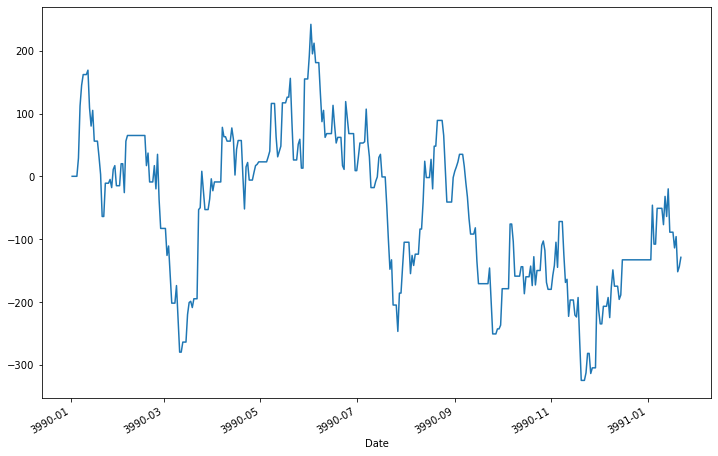

In [384]:
Cum_df["PnL"].cumsum().plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

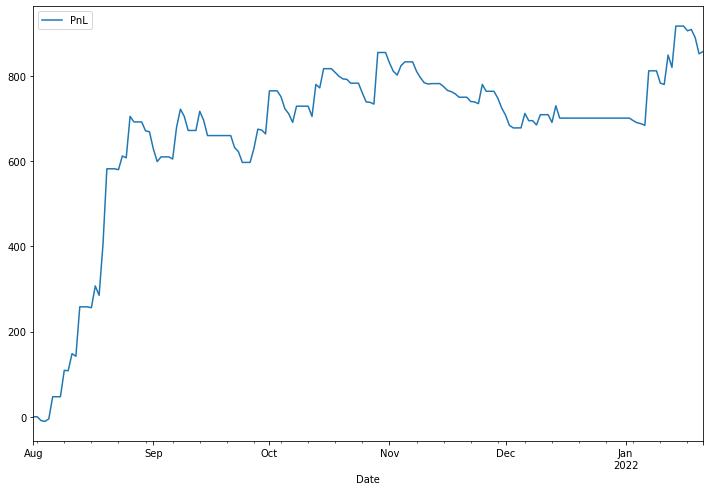

In [47]:
Cum_df.cumsum().plot(figsize=(12,8))

In [389]:
import json
data_path = os.path.join(parent, "HistoricData", "MXF")
if not os.path.isdir(data_path):
    os.makedirs(data_path)
for k, v in dfs.items():
    tdStr = k.strftime("%Y-%m-%d")
    with open(os.path.join(data_path, f"MXF_{tdStr}.json"), 'w') as f:
        v = v.reset_index()
        v.datetime = v.datetime.apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f"))
        json.dump(list(v.T.to_dict().values()), f)